In [1]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)
#from pypointmatcher import pointmatcher as pm, pointmatchersupport as pms
#PM = pm.PointMatcher
#DP = PM.DataPoints

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy

#1 11 2021
#Dist_prism_12 = 1.0398341231585624*1000
#Dist_prism_13 = 0.818424700118086*1000
#Dist_prism_23 = 0.8806156053859284*1000
#Dist_GPS_12 = 0.835637436093363*1000
#Dist_GPS_13 = 0.7812173648662254*1000
#Dist_GPS_23 = 0.5166745729506486*1000

P1 = np.array([[1,0,0,0.5],[0,1,0,-0.25],[0,0,1,0.3],[0,0,0,1]])
P2 = np.array([[1,0,0,-0.1],[0,1,0,0.4],[0,0,1,0.2],[0,0,0,1]])
P3 = np.array([[1,0,0,-0.7],[0,1,0,0],[0,0,1,0.4],[0,0,0,1]])

# Distance in meter
Dist_prism_12 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P2[0,3],P2[1,3],P2[2,3]])),3)
Dist_prism_13 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
Dist_prism_23 = round(np.linalg.norm(np.array([P2[0,3],P2[1,3],P2[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
cov_prism = np.array([[0.002,0,0],[0,0.002,0],[0,0,0.002]])
D12_wref = round(np.sqrt(np.linalg.norm(P1-P2)*np.linalg.norm(P1-P2)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
D13_wref = round(np.sqrt(np.linalg.norm(P1-P3)*np.linalg.norm(P1-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
D23_wref = round(np.sqrt(np.linalg.norm(P2-P3)*np.linalg.norm(P2-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
#print(Dist_prism_12,Dist_prism_13,Dist_prism_23)
#print(D12_wref,D13_wref,D23_wref)

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
tfuu = importlib.reload(tfuu)
path = "./data/simulation/"
trajectoire = "1"

time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file(path+trajectoire+"_s_sync_p_1"+".csv")
time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file(path+trajectoire+"_s_sync_p_2"+".csv")
time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file(path+trajectoire+"_s_sync_p_3"+".csv")

#time_trimble_1_ref, trimble_1_ref = tfuu.read_point_data_csv_file(path+trajectoire+"_ref_p_1"+".csv")

print(time_trimble_1[1]-time_trimble_1[0])

0.5


 /home/norlab/Repo_git/code_publication_IROS2022_MaximeVaidis/scripts/theodolite_utils.py:206: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number sub-trajectories: 1


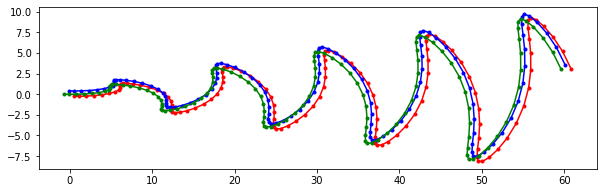

In [3]:
# Work on the data with 3 prisms and 3 theodolites
tfu = importlib.reload(tfu)
# Slipt the data into different interval according to the timestamps of the measurements
limit_time_interval = 3    #4 seconds max
list_interval, list_time = tfu.split_time_interval_all_data(time_trimble_1, time_trimble_2, time_trimble_3, limit_time_interval)
# Keep only the intervals where the three theodlites have done some measurements at the same time
limit_search = 4
list_trajectories_split = tfu.merge_interval(list_interval, list_time, time_trimble_1, time_trimble_2, time_trimble_3, limit_search)
print("Number sub-trajectories:",len(list_trajectories_split))
# Plot subtrajectory for debug
tfu.plot_subtrajectory_result(0, list_trajectories_split, trimble_1, trimble_2, trimble_3)

In [17]:
import scripts.theodolite_utils as tfu
tfu = importlib.reload(tfu)
GPf = importlib.reload(GPf)
save = False
Mode = "GP"
#Mode = "All"
begin = 0
end = 60
rate = 10  #Hz
T_prediction_init = np.atleast_2d(np.arange(begin, end, 1/rate)).T
size_interval = 10
num_restarts_MGPO=5
num_restarts_GP=5
verbose=False

Prediction_1_MGPO = []
Prediction_2_MGPO = []
Prediction_3_MGPO = []
Prediction_1_GP = []
Prediction_2_GP = []
Prediction_3_GP = []

compteur = 0
max_compteur = len(T_prediction_init)

for i in T_prediction_init:
    isInInterval, time_1, time_2, time_3, traj_1, traj_2, traj_3 = GPf.check_if_in_interval(list_trajectories_split, size_interval, 
                  time_trimble_1, time_trimble_2, time_trimble_3, trimble_1, trimble_2, trimble_3, i[0])
    if(isInInterval == True):
        index_1, index_2, index_3 = GPf.define_window_training(time_1, time_2, time_3, size_interval, i[0])
        if(Mode == "MGPO" or Mode == "All"):
            T_MGPO, S_MGPO = GPf.data_training_MGPO(time_1, time_2, time_3, traj_1, traj_2, traj_3, index_1, index_2, index_3)
            m = GPf.training_MGPO(num_restarts_MGPO, verbose, T_MGPO, S_MGPO)
            P1_MGPO, P2_MGPO, P3_MGPO = GPf.unit_prediction_MGPO(i[0], m)
            Prediction_1_MGPO.append(P1_MGPO)
            Prediction_2_MGPO.append(P2_MGPO)
            Prediction_3_MGPO.append(P3_MGPO)
        if(Mode == "GP" or Mode == "All"):
            T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_GP(time_1, time_2, time_3, traj_1, 
                                                                 traj_2, traj_3, index_1, index_2, index_3)
            mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = GPf.training_GP(num_restarts_GP, verbose, T1, X1, Y1,
                                                                      Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3)
            P1_GP, P2_GP, P3_GP = GPf.unit_prediction_GP(i[0], mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
            Prediction_1_GP.append(P1_GP)
            Prediction_2_GP.append(P2_GP)
            Prediction_3_GP.append(P3_GP)
            
    if(compteur/max_compteur*100 % 10 == 0):
        print(compteur/max_compteur*100)
    compteur=compteur+1
    
print("Finished !")
            
if(Mode == "MGPO" or Mode == "All"):
    path = "./data/simulation/"
    trajectoire = "1-6"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_MGPO, path+trajectoire+ "_MGPO_s_sync_p_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_MGPO, path+trajectoire+ "_MGPO_s_sync_p_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_MGPO, path+trajectoire+ "_MGPO_s_sync_p_3.csv")
if(Mode == "GP" or Mode == "All"):
    path = "./data/simulation/"
    trajectoire = "1-6"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_GP, path+trajectoire+ "_GP_s_sync_p_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_GP, path+trajectoire+ "_GP_s_sync_p_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_GP, path+trajectoire+ "_GP_s_sync_p_3.csv")

 /home/norlab/python-env/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:overflow encountered in multiply
 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:overflow encountered in square
 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply
 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:overflow encountered in multiply
 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in subtract
 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/

0.0


 /home/norlab/python-env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in multiply


10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
Finished !


In [20]:
%matplotlib notebook
error_euclidian_MGPO, distance_wasserstein_MGPO, error_wasserstein_diff_MGPO, T_prediction = GPf.error_calculation(Prediction_1_MGPO, 
            Prediction_2_MGPO, Prediction_3_MGPO, Dist_prism_12, Dist_prism_13, Dist_prism_23, D12_wref, D13_wref, D23_wref)
error_e_MGPO = np.array(error_euclidian_MGPO)
distance_w_MGPO = np.array(distance_wasserstein_MGPO)
error_w_diff_MGPO = np.array(error_wasserstein_diff_MGPO)
print("Mean e: ", np.mean(error_e_MGPO[:,0]),np.mean(error_e_MGPO[:,1]),np.mean(error_e_MGPO[:,2]))
print("Variance e: ", np.std(error_e_MGPO[:,0]),np.std(error_e_MGPO[:,1]),np.std(error_e_MGPO[:,2]))
print("Mean w: ", np.mean(error_w_diff_MGPO[:,0]),np.mean(error_w_diff_MGPO[:,1]),np.mean(error_w_diff_MGPO[:,2]))
print("Variance w: ", np.std(error_w_diff_MGPO[:,0]),np.std(error_w_diff_MGPO[:,1]),np.std(error_w_diff_MGPO[:,2]))
diff_e_w = error_e_MGPO[:,0:3]-error_w_diff_MGPO
plt.figure(0)
plt.plot(T_prediction, error_e_MGPO[:,0], label="e12")
plt.plot(T_prediction, error_e_MGPO[:,1], label="e13")
plt.plot(T_prediction, error_e_MGPO[:,2], label="e23")
#plt.plot(T_prediction,distance_w_MGPO[:,0], label="w12")
#plt.plot(T_prediction, distance_w_MGPO[:,1], label="w13")
#plt.plot(T_prediction, distance_w_MGPO[:,2], label="w23")
plt.plot(T_prediction, error_w_diff_MGPO[:,0], label="dw12")
plt.plot(T_prediction, error_w_diff_MGPO[:,1], label="dw13")
plt.plot(T_prediction, error_w_diff_MGPO[:,2], label="dw23")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylim([0, 1000])
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Mean e:  0.23709361905785992 0.16123938538815877 0.34805603147539405
Variance e:  0.14045529087475617 0.011367909749436038 0.14104510252272084
Mean w:  0.23670603151694575 0.1618073676485639 0.34818020470727556
Variance w:  0.1364540114415735 0.012870080282761666 0.14227306787201463


<IPython.core.display.Javascript object>


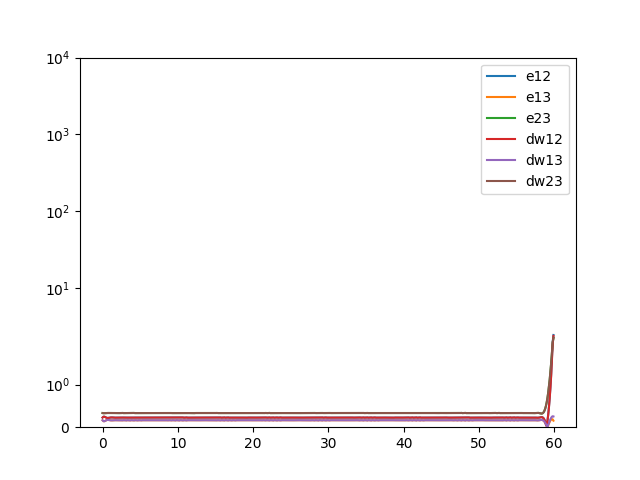

In [22]:
%matplotlib notebook
error_euclidian_GP, distance_wasserstein_GP, error_wasserstein_diff_GP, T_prediction = GPf.error_calculation(Prediction_1_GP, 
            Prediction_2_GP, Prediction_3_GP, Dist_prism_12, Dist_prism_13, Dist_prism_23, D12_wref, D13_wref, D23_wref)
error_e_GP = np.array(error_euclidian_GP)
distance_w_GP = np.array(distance_wasserstein_GP)
error_w_diff_GP = np.array(error_wasserstein_diff_GP)
print("Mean e: ", np.mean(error_e_GP[:,0]),np.mean(error_e_GP[:,1]),np.mean(error_e_GP[:,2]))
print("Variance e: ", np.std(error_e_GP[:,0]),np.std(error_e_GP[:,1]),np.std(error_e_GP[:,2]))
print("Mean w: ", np.mean(error_w_diff_GP[:,0]),np.mean(error_w_diff_GP[:,1]),np.mean(error_w_diff_GP[:,2]))
print("Variance w: ", np.std(error_w_diff_GP[:,0]),np.std(error_w_diff_GP[:,1]),np.std(error_w_diff_GP[:,2]))
diff_e_w = error_e_GP[:,0:3]-error_w_diff_GP
plt.figure(0)
plt.plot(T_prediction, error_e_GP[:,0], label="e12")
plt.plot(T_prediction, error_e_GP[:,1], label="e13")
plt.plot(T_prediction, error_e_GP[:,2], label="e23")
#plt.plot(T_prediction, distance_w_GP[:,0], label="w12")
#plt.plot(T_prediction, distance_w_GP[:,1], label="w13")
#plt.plot(T_prediction, distance_w_GP[:,2], label="w23")
plt.plot(T_prediction, error_w_diff_GP[:,0], label="dw12")
plt.plot(T_prediction, error_w_diff_GP[:,1], label="dw13")
plt.plot(T_prediction, error_w_diff_GP[:,2], label="dw23")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylim([0, 10000])
plt.show()

In [9]:
import scripts.theodolite_utils as tfu
tfu = importlib.reload(tfu)
tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_GP, "./data/simulation/prediction_GP_sub_prism_1_3.csv")
tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_GP, "./data/simulation/prediction_GP_sub_prism_2_3.csv")
tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_GP, "./data/simulation/prediction_GP_sub_prism_3_3.csv")


Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !


In [67]:
tfu = importlib.reload(tfu)
tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_MGPO, path+trajectoire+ "_MGPO_s_sync_p_1.csv")
tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_MGPO, path+trajectoire+ "_MGPO_s_sync_p_2.csv")
tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_MGPO, path+trajectoire+ "_MGPO_s_sync_p_3.csv")

Conversion done !
Conversion done !
Conversion done !


In [23]:
save = True
if(Mode == "MGPO" or Mode == "All"):
    path = "./data/simulation/"
    trajectoire = "1-5"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_MGPO, path+trajectoire+ "_MGPO_s_sync_p_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_MGPO, path+trajectoire+ "_MGPO_s_sync_p_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_MGPO, path+trajectoire+ "_MGPO_s_sync_p_3.csv")
if(Mode == "GP" or Mode == "All"):
    path = "./data/simulation/"
    trajectoire = "1-5"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_GP, path+trajectoire+ "_GP_s_sync_p_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_GP, path+trajectoire+ "_GP_s_sync_p_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_GP, path+trajectoire+ "_GP_s_sync_p_3.csv")

Conversion done !
Conversion done !
Conversion done !
